In [2]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Layer, Lambda, LSTM, TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
from IPython.display import Image
from collections import deque
from statsmodels.tsa.arima_model import ARIMA
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import itertools
import copy
import random
import pickle
import time
import os
import io
from importnb import Notebook, reload
with Notebook(): 
    import Utilities
# Disables error in custom keras-layer
tf.compat.v1.disable_eager_execution()

In [3]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

config = {
    'embed_dim': 300,    # Dimensions to use for the word embedding
    'lookback': 3,       # How far back to collect data in the recurrent layer (days)
    'delay': 3,          # How far ahead to predict data (days)
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.8,  # Part of data to be used for training
    'val_part' : 0.1,    # Part of data to be used for validation
    'test_part' : 0.1,   # Part of data to be used for testing
    'series': '1 YEAR',   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'vocab_size': 15000,  # Include only the 'vocab_size' most common words 
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [4]:
# Load data 
news_path = ONEDRIVE_PATH /  "Input Data/financial_headlines_20061020-20131119.pkl"
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)
text = Utilities.preprocess_text(data)

In [200]:
# Tokenize the text data 
tokenizer = Tokenizer(num_words=config['vocab_size'])
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text)

In [201]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = ONEDRIVE_PATH / "Embeddings/GloVe/saved.42B.300d.pkl"
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [276]:
# Create embedding matrix with shape (vocab_size, embed_dimension)
embedding_weights = np.zeros((config['vocab_size'], config['embed_dim']))
# Add pre-trained weights from GloVe
for word,index in word_index.items(): 
    if index > config['vocab_size']: 
        break
    temp_emb = emb_dict.get(word)
    if temp_emb is not None: 
        embedding_weights[index - 1] = temp_emb
    else: 
        embedding_weights[index - 1] = np.random.normal(size=config['embed_dim'])

In [277]:
config['max_len'] = max([len(sent) for sent in sequences])
print("Actual maximum length of one day news:",config['max_len'])

# Pad the text data so we get a matrix of shape (n,max_len)
x = np.zeros((len(sequences), config['max_len']))
for i,sent in enumerate(sequences): 
    if len(sent) > config['max_len']: 
        x[i] = sent[:config['max_len']]
    else: 
        x[i,:len(sent)] = sent

Actual maximum length of one day news: 950


In [279]:
# Need to remove some rows from the word embedding-matrix,
# these numbers are specified in Utilities.fit_all_models()
rm_start_rows = max(config['lookback'],5) + 1
rm_end_rows = config['delay']
x = x[rm_start_rows : -rm_end_rows]

In [280]:
y = Utilities.load_binary_labels(config)

Loaded previously constructed labels.


In [281]:
(x_train,y_train), (x_val,y_val), (x_test,y_test) = Utilities.shuffle_and_partition(x,y,test_part=0.1,val_part=0.2,sequences=True,config=config)
print("Shape of x_train, y_train: ",x_train.shape, y_train.shape)
print("Shape of x_val, y_val: ",x_val.shape, y_val.shape)
print("Shape of x_test, y_test: ",x_test.shape, y_test.shape)


Shape of x_train, y_train:  (1799, 3, 950) (1799,)
Shape of x_val, y_val:  (513, 3, 950) (513,)
Shape of x_test, y_test:  (255, 3, 950) (255,)


## Model 
This model aims to take the chronology of news over a period into account. 

In [321]:
# Define some help functions for custom layer and hyper parameter optimization

# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=3),0),tf.float32))
    return K.sum(x,axis=2) / non_zero

def merge_output_shape(input_shape):
    return (input_shape[0], input_shape[2])


def train_and_format(x,y,bs,epochs, results, layers, nodes,lr,verbose=0):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_loss'][-5:]),
                                                temp_history, model, layers, 
                                                nodes, bs], 
                                                name=name,index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size']))
def create_lstm(lstm_units,lr):
    lstm_layers = len(lstm_units)
    model = Sequential() 
    model.add(TimeDistributed(Embedding(input_dim=config['vocab_size'],
                                        output_dim=config['embed_dim'],
                                        input_length=config['max_len'],
                                        weights=[embedding_weights]), input_shape=x_train.shape[1:] ))
    model.add(Lambda(merge_embeddings, output_shape=merge_output_shape))
    idx = 0
    while lstm_layers > idx + 1: 
        model.add(LSTM(lstm_units[idx], return_sequences=True))
        idx += 1
    model.add(LSTM(lstm_units[-1],return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
    return model

def train_and_format(x,y,x_val,y_val,bs,epochs, results, layers, nodes, lr, verbose=0):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_data=(x_val, y_val), epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_loss'][-3:]),
                                                temp_history, model, layers, 
                                                nodes, bs, lr], 
                                                name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))

In [323]:
n_layers = [1,2]
n_units = [10,50,100]
batch_sizes = [16]
learning_rates = [0.01]
epochs = 10
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes', 'Batch Size', 'Learning Rate'])
n_configs = sum([len(n_units)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
verbose = 1
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    # Ugliest code ever written, fix?
    if layers == 1: node_configs = list(itertools.product(n_units))
    elif layers == 2: node_configs = list(itertools.product(n_units, n_units))
    elif layers == 3: node_configs = list(itertools.product(n_units, n_units, n_units))
    elif layers == 4: node_configs = list(itertools.product(n_units, n_units, n_units, n_units))
    for bs in batch_sizes: 
        for temp_nodes in node_configs: 
            for lr in learning_rates:
                ctr += 1 
                model = create_lstm(temp_nodes,lr)
                results = train_and_format(x_train, y_train, x_val, y_val, bs, epochs, results, layers, temp_nodes,lr,verbose=verbose)
                if verbose: 
                    print("{} %     ".format(round(100 * ctr / n_configs,2)))
                else:
                    print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')


Testing 12 combinations. 
Train on 1799 samples, validate on 513 samples
Epoch 1/10
1799/1799 [==============================] - 10s 6ms/sample - loss: 0.6784 - acc: 0.5970 - val_loss: 0.6347 - val_acc: 0.7466
Epoch 2/10
1799/1799 [==============================] - 8s 4ms/sample - loss: 0.6750 - acc: 0.5992 - val_loss: 0.6363 - val_acc: 0.7466
Epoch 3/10
1799/1799 [==============================] - 8s 4ms/sample - loss: 0.6740 - acc: 0.5992 - val_loss: 0.6296 - val_acc: 0.7466
Epoch 4/10
1799/1799 [==============================] - 8s 4ms/sample - loss: 0.6667 - acc: 0.6037 - val_loss: 0.5970 - val_acc: 0.7466
Epoch 5/10
1799/1799 [==============================] - 8s 5ms/sample - loss: 0.6342 - acc: 0.6265 - val_loss: 0.5856 - val_acc: 0.7485
Epoch 6/10
1799/1799 [==============================] - 8s 5ms/sample - loss: 0.5943 - acc: 0.6759 - val_loss: 0.6273 - val_acc: 0.6140
Epoch 7/10
1799/1799 [==============================] - 8s 5ms/sample - loss: 0.5329 - acc: 0.7465 - val_loss:

1799/1799 [==============================] - 9s 5ms/sample - loss: 0.6653 - acc: 0.6014 - val_loss: 0.6016 - val_acc: 0.7466
Epoch 6/10
1799/1799 [==============================] - 9s 5ms/sample - loss: 0.6559 - acc: 0.6014 - val_loss: 0.5715 - val_acc: 0.7524
Epoch 7/10
1799/1799 [==============================] - 9s 5ms/sample - loss: 0.6352 - acc: 0.6431 - val_loss: 0.5805 - val_acc: 0.7466
Epoch 8/10
1799/1799 [==============================] - 9s 5ms/sample - loss: 0.5905 - acc: 0.6893 - val_loss: 0.7089 - val_acc: 0.5497
Epoch 9/10
1799/1799 [==============================] - 9s 5ms/sample - loss: 0.5044 - acc: 0.7610 - val_loss: 0.6393 - val_acc: 0.6433
Epoch 10/10
1799/1799 [==============================] - 9s 5ms/sample - loss: 0.4361 - acc: 0.8032 - val_loss: 0.7380 - val_acc: 0.5965
100.0 %     


In [324]:
k = 3
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 3 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"16_1_(100,)",0.757093,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,1,"(100,)",16,0.01
"16_1_(50,)",0.931713,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,1,"(50,)",16,0.01
"16_1_(10,)",0.861456,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,1,"(10,)",16,0.01


Nodes: (100,), Mean validation accuracy: 0.7570933001662368


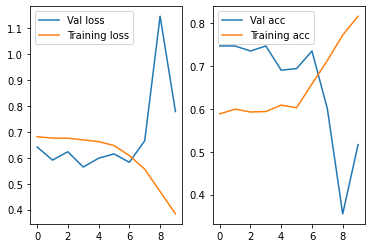

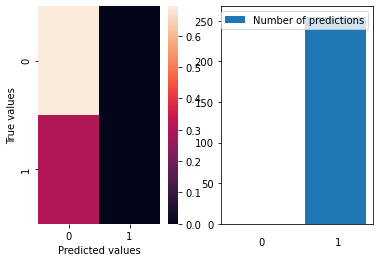

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       177
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       255
   macro avg       0.35      0.50      0.41       255
weighted avg       0.48      0.69      0.57       255

Nodes: (50,), Mean validation accuracy: 0.9317129483929387


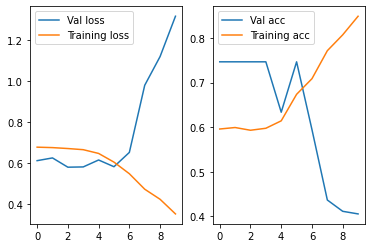

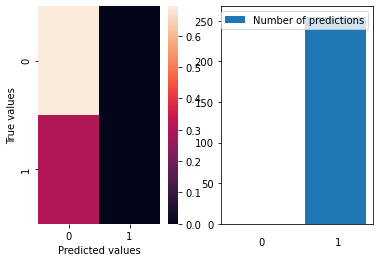

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       177
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       255
   macro avg       0.35      0.50      0.41       255
weighted avg       0.48      0.69      0.57       255

Nodes: (10,), Mean validation accuracy: 0.861456082645088


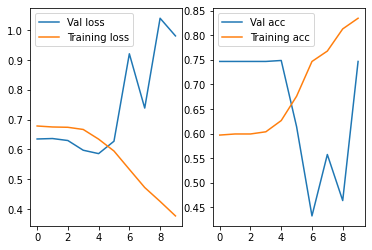

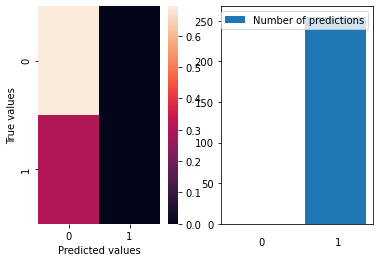

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       177
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       255
   macro avg       0.35      0.50      0.41       255
weighted avg       0.48      0.69      0.57       255



In [326]:
for i in k_best: 
    print(f"Nodes: {results.iloc[i]['Nodes']}, Mean validation accuracy: {results.iloc[i]['Mean Val Acc']}")
    plt.subplot(121)
    plt.plot(results.iloc[i]['History'].history['val_loss'],label='Val loss')
    plt.plot(results.iloc[i]['History'].history['loss'],label='Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(results.iloc[i]['History'].history['val_acc'],label='Val acc')
    plt.plot(results.iloc[i]['History'].history['acc'],label='Training acc')
    plt.legend()
    plt.show()
    results.iloc[i]['Model'].evaluate(x_test,y_test,verbose=0)
    # Calculate the predictions on the test set 
    y_test_pred_prob = model.predict(x_test)
    y_test_pred = np.zeros(len(y_test))
    for i,row in enumerate(y_test_pred_prob): 
        y_test_pred[i] = np.argmax(row)
        
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    plt.subplot(121)
    ax = sn.heatmap(conf_mat)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    Utilities.plot_binary_predictions(y_test_pred,subplot=122,show=True)
    print(classification_report(y_test,y_test_pred))